In [1]:
using DrWatson
@quickactivate "WiFi-Imager"
includet(srcdir("funcs.jl"))
using CairoMakie

In [2]:
includet(srcdir("makie_theme.jl"))

In [3]:
doi_size = 0.3
grid_number = 50
tx_xs = [0.6, 0.6, 0.6, 0.255, 0.0, -0.255, -0.6, -0.6, -0.6, -0.255, 0.0, 0.255]
tx_ys = [0.255, 0.0, -0.255, -0.6, -0.6, -0.6, -0.255, 0.0, 0.255, 0.6, 0.6, 0.6]
all_esp_num = 44
cen_freq = 2.462e9
air_permittivity = 1.0 + 0.0im
dis_ant = 0.085
Ni = length(tx_xs)
tx_pp = [-3, 0, 3]
tx_scale = Ni ÷ 4
Ns = all_esp_num - Ni
L = 4
rx_xs = vcat(repeat(tx_xs[(1 * tx_scale):(1 * tx_scale)], div(Ns, 4)),
    [x for x in div(all_esp_num - 4, 8):-1:div(-(all_esp_num - 4), 8) if x ∉ tx_pp] .*
    dis_ant,
    repeat(tx_xs[(3 * tx_scale):(3 * tx_scale)], div(Ns, 4)),
    [x for x in div(-(all_esp_num - 4), 8):1:div((all_esp_num - 4), 8) if x ∉ tx_pp] .*
    dis_ant)
rx_ys = vcat(
    [x
     for x in div((all_esp_num - 4), 8):-1:div(-(all_esp_num - 4), 8) if x ∉ tx_pp] .*
    dis_ant,
    repeat(tx_ys[(2 * tx_scale):(2 * tx_scale)], div(Ns, 4)),
    [x for x in div(-(all_esp_num - 4), 8):1:div((all_esp_num - 4), 8) if x ∉ tx_pp] .*
    dis_ant,
    repeat(tx_xs[(4 * tx_scale):(4 * tx_scale)], div(Ns, 4)))
Rx_pos = [rx_xs'; rx_ys']
Tx_pos = [tx_xs'; tx_ys']
size(Rx_pos)

(2, 32)

In [4]:
parameters_all = map(
        frequency -> ConstantParameter(freq = frequency,
            doi_size_x = doi_size,
            doi_size_y = doi_size,
            grid_number_x = grid_number,
            grid_number_y = grid_number,
            txs_pos = Tx_pos,
            rxs_pos = Rx_pos),
        [cen_freq])
Ei_in_rxs_all, Ei_in_domain_all, GS_all, GDZ_all, V⁺_all, V⁻_all, GDV_neg_all, GSV_neg_all = get_shared_variables(
            parameters_all,
            L)

(Array{ComplexF64}[[-4.67694921453873 - 3.5676634046940316im -2.3489381044405007 - 0.1371931537587095im … 1.0700792483809463 - 1.1895084708334234im 1.1395663287056077 - 2.3202687744932433im; -3.765796106188591 + 11.145720442613149im 0.7773787018254124 + 2.836582694914799im … -1.0528984015735203 - 1.1090713203257783im -2.209382582980605 + 0.6906283493734691im; … ; 2.5345008625099754 - 2.8929577919873326im 2.741671865537934 + 0.15261694578870716im … 2.0455730879145997 + 0.2788389264449433im 2.452299737123215 + 1.3809482533800215im; -5.277292122336096 - 2.1916316022587385im -3.130789345918097 + 0.8080477304820404im … -1.8262494962678129 - 0.045161288070778134im 1.4072730575884382 - 2.186267382163916im]], Array{ComplexF64}[[0.4154538265549027 - 1.2580902686866606im -0.025701822256715967 - 1.313245463982996im … 1.7846841941525584 + 1.1062203652698506im 1.6299378316047204 + 0.26360462217778774im; 0.35736935044190027 - 1.274199865452135im 0.05134424041539288 - 1.3144568826659768im … 2.0050110

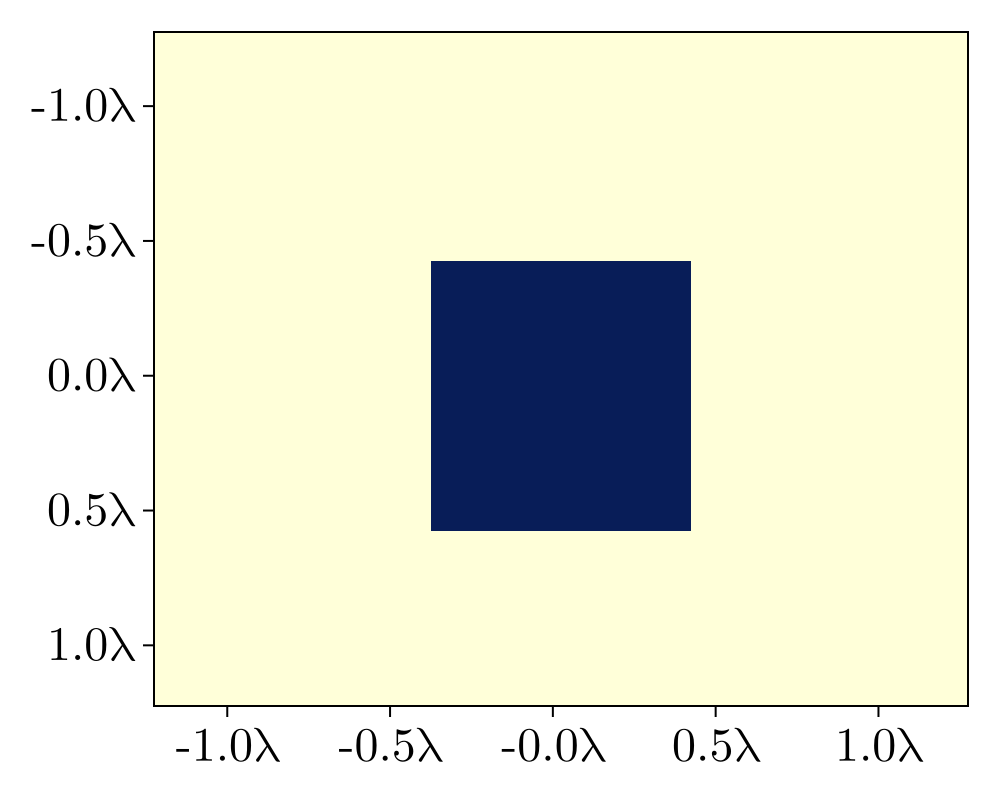

In [5]:
regeangle_pos = [[-35,25,-35,-25,25,-25,25,25],]./500
scatterer = get_scatterer(regeangle_pos,[1.6],parameters_all[1])
let 
    fig = Figure(; size = (500, 400), rasterize=8)
    ax1 = Axis(fig[1, 1];xticks=(5:10:45,["$(round(parameters_all[1].grid_xs[i]/parameters_all[1].λ, digits=1))λ" for i in 5:10:45]),yticks=(5:10:45,["$(round(parameters_all[1].grid_ys[i]/parameters_all[1].λ, digits=1))λ" for i in 5:10:45]))
    heatmap!(ax1,abs.(scatterer),colormap=:YlGnBu)
    # save("/home/sf/paper/WiFimager/figures/born_gt.pdf",fig)
    fig
end


In [6]:
frequency = cen_freq
sub_freq_ids = 1
parameters = parameters_all[sub_freq_ids]
Ei_in_rxs = Ei_in_rxs_all[sub_freq_ids]
Ei_in_domain = Ei_in_domain_all[sub_freq_ids]
GS = GS_all[sub_freq_ids]
GDZ = GDZ_all[sub_freq_ids]
V⁺, V⁻ = (V⁺_all[sub_freq_ids]), (V⁻_all[sub_freq_ids])
scatter_centroid_xs, scatter_centroid_ys, object_grid_indices = find_grids_with_object(
    parameters,
    scatterer)
impedance_in_domain = get_impedance_in_domain(parameters,
    vec(scatterer)[object_grid_indices],
    scatter_centroid_xs,
    scatter_centroid_ys)
current = get_induced_current(parameters,
    impedance_in_domain,
    Ei_in_domain[object_grid_indices, :],
    object_grid_indices;)
Es = get_scattered_field(parameters, current, GS;);

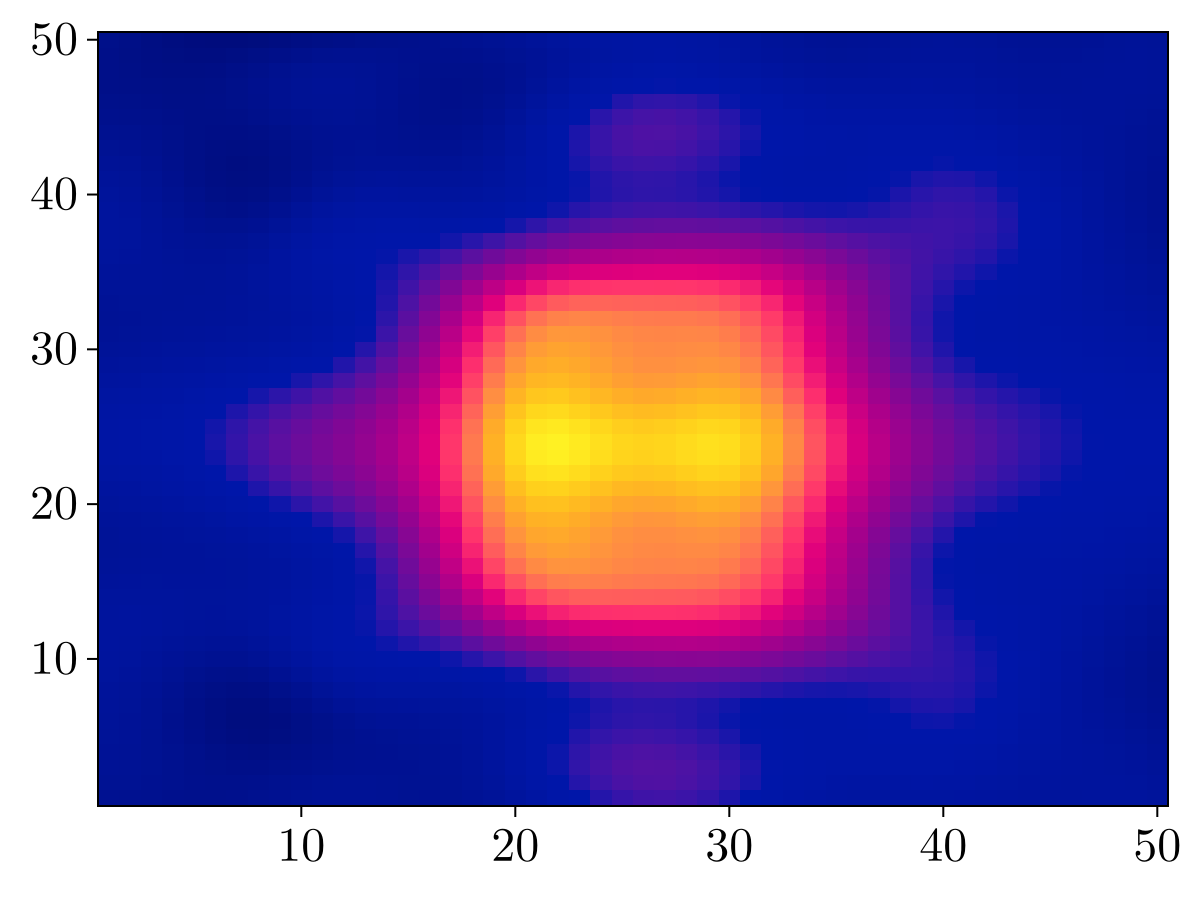

In [7]:
# BP
γ = sum(Es .* conj(GS*GS'*Es), dims=1) ./ sum(abs2.(GS*GS'*Es),dims=1)
J_bp = repeat(γ, length(scatterer),1) .* (GS'*Es)
Et = Ei_in_domain .+ GD(J_bp, GDZ)
num = sum(J_bp .* conj(Et),dims=2)
den = sum(abs2.(Et),dims=2)
ξ_bp = reshape(num ./ den, grid_number, grid_number)
heatmap(real.(ξ_bp ./ (-1im * parameters.k₀ / parameters.η)) .+ 1.0)

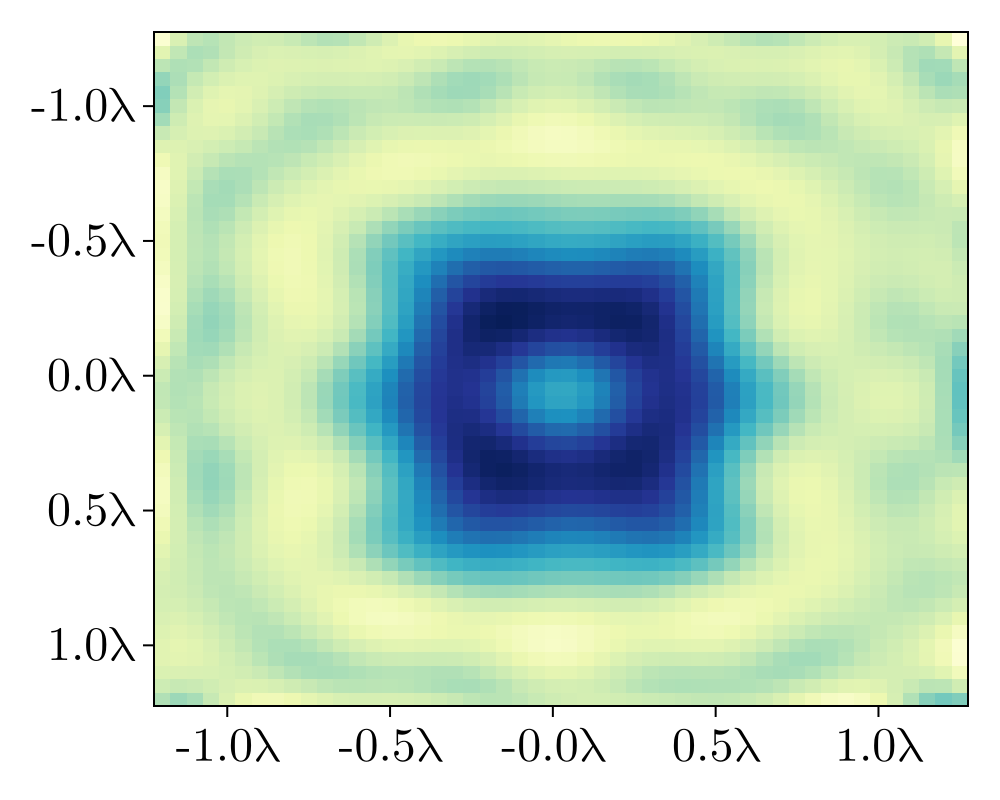

In [8]:
using LinearAlgebra
α = 0.01
A = zeros(ComplexF64, size(Ei_in_domain))
function get_born_coefficient(GS, E_inc_one_tx)
    A = GS * Diagonal(vec(E_inc_one_tx))
    return A
end
As = [get_born_coefficient(GS, Ei_in_domain[:, i]) for i in 1:size(Ei_in_domain, 2)]
coefficient = sum([(A' * A + α * I) for A in As])
A_b = sum([As[i]' * Es[:, i] for i in 1:size(Es, 2)])
ξ_born = reshape(coefficient \ A_b, grid_number, grid_number)

let 
    fig = Figure(; size = (500, 400), rasterize=8)
    ax1 = Axis(fig[1, 1];xticks=(5:10:45,["$(round(parameters_all[1].grid_xs[i]/parameters_all[1].λ, digits=1))λ" for i in 5:10:45]),yticks=(5:10:45,["$(round(parameters_all[1].grid_ys[i]/parameters_all[1].λ, digits=1))λ" for i in 5:10:45]))
    heatmap!(ax1,real.(ξ_born ./ (-1im * parameters.k₀ / parameters.η)) .+ 1.0,colormap=:YlGnBu)
    # save("/home/sf/paper/WiFimager/figures/born_res.pdf",fig)
    fig
end


In [67]:
size(Ei_in_domain)

(2500, 12)

In [13]:
using Zygote,Optimization,OptimizationOptimJL

rosenbrock = (ξ, Es) -> begin
        temp = GS * Diagonal(ξ) * Ei_in_domain
        return sum(abs2.(temp - Es)) + α * sum(abs2.(ξ))
    end

ξ₀ = rand(ComplexF64, size(Ei_in_domain,1))
optf = Optimization.OptimizationFunction(rosenbrock, Optimization.AutoZygote())
prob = Optimization.OptimizationProblem(optf, ξ₀, Es)
using BenchmarkTools
@btime ξ_born_zygote = reshape(Optimization.solve(prob, LBFGS()).u, grid_number, grid_number);


  12.515 s (202096 allocations: 100.99 GiB)


In [ ]:
heatmap(real.(ξ_born_zygote ./ (-1im * parameters.k₀ / parameters.η)) .+ 1.0)

In [10]:
ξ_gt = vec(scatterer .- 1) .* (-1im * parameters.k₀ / parameters.η)
unique(ξ_gt) 

2-element Vector{ComplexF64}:
 0.0 + 0.0im
 0.0 - 0.0821785899068694im

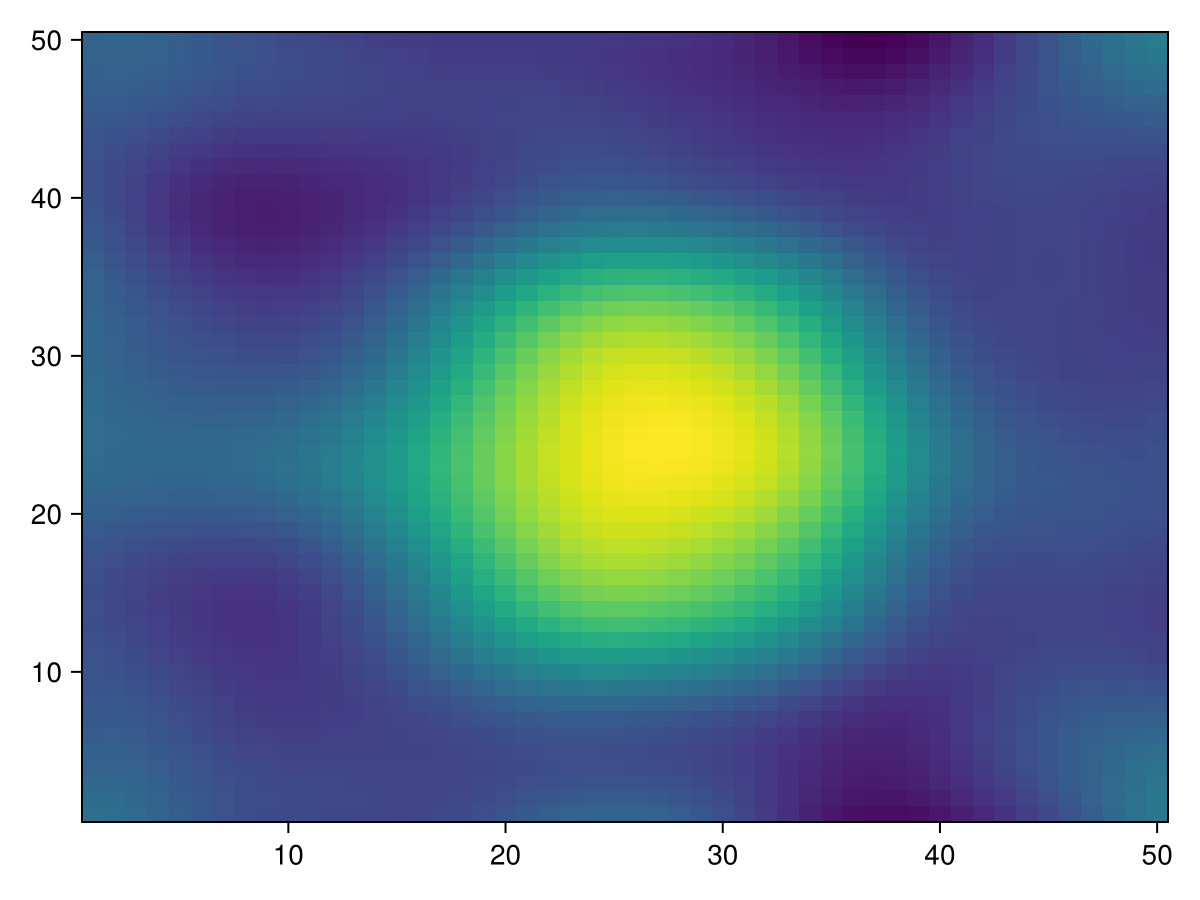

In [82]:
using OptimizationOptimisers
CSI = Es + (Ei_in_rxs)
F = ComplexF32.(abs2.(CSI))
α_phaseless = 200
rosenbrock_phaseless = (ξ, F) -> begin
        temp = abs2.(GS * Diagonal(ξ) * Ei_in_domain .+ Ei_in_rxs)
        return sum(abs2.(temp-F)) + α_phaseless * sum(abs2.(ξ))
    end

ξ₀ = -0.1 .* rand(ComplexF64,size(Ei_in_domain,1))
optf_phaseless = Optimization.OptimizationFunction(rosenbrock_phaseless, Optimization.AutoZygote())
prob_phaseless = Optimization.OptimizationProblem(optf_phaseless, ξ₀, F)
ξ_born_phaseless = reshape(Optimization.solve(prob_phaseless, LBFGS()).u, grid_number, grid_number)
heatmap(real.(ξ_born_phaseless ./ (-1im * parameters.k₀ / parameters.η)) .+ 1.0)